In [1]:
# Note: Before starting the slideshow, make sure you run this code as it
# provides helper functions that the other slides need...
#
# Other than that, you can ignore this content as it won't show up in the slideshow.
#
# It's a helper function that makes it easier to show OpenCV images directly
# in the notebook environment. When using OpenCV locally, you'll want to use
# `cv2.imshow(name, img)` instead.

import numpy as np
import cv2
import math

# Notebook setup + convenience functions
%matplotlib inline
import matplotlib.pyplot as plt

def force_bgr(img):
    '''Forces image to 3-channel representation if grayscale'''
    if len(img.shape) == 2 or img.shape[2] == 1:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def imshow(*args):
    '''Helper function to show images, because matplotlib and OpenCV aren't a perfect match'''
    fig = plt.figure()
    for i, img in enumerate(args):
        fig.add_subplot(1,len(args),i+1)
        plt.imshow(cv2.cvtColor(force_bgr(img), cv2.COLOR_BGR2RGB))

def blur(src, radius):
    ksize = int(2 * round(radius) + 1)
    return cv2.blur(src, (ksize, ksize))


# <center>Image processing using</center>

## <center>OpenCV + Python</center>

<br/>
<center><b>Tim Winters</b><center>
<center>Created by Dustin Spicuzza (Team 2423/1418)</center>
<br/>
<center>September 10, 2016</center>
<br/>
<center><span style="color: #ababab">NE FIRST University Day</span></center>

# Agenda

* Why OpenCV + Python?
* Image filtering demo
* pynetworktables

# Image processing

* FRC Teams do it a lot of ways
    * NIVision (LabVIEW)
    * GRIP (Uses OpenCV as engine)
    * OpenCV (various custom stuff)
    
* We're going to talk about OpenCV

# Why OpenCV?

* Originally developed by Intel
* It has thousands of image processing related algorithms and functions available
  * Highly optimized and reliable
  * Has building blocks that fit together
* Lets you do complex image processing without needing to understand the math
  * If you understand the math, it helps!

# Why OpenCV?

* Bindings for multiple languages
    * C/C++
    * Java
    * Python
* Multiple platforms supported
    * Windows
    * Linux
    * OSX
    * Android
* Oh, and it’s **FREE**!

# What OpenCV Provides

* Image I/O:
    * Read/Write images from disk
    * Use native OS functionality to interface with cameras
* Image Segmentation
    * Edge finding
    * Contour detection
    * Thresholding

# What OpenCV Provides

* Face detection
* Motion tracking
* Stereo vision support
* Support for GPU acceleration
* Machine learning operations
    * Classifiers
    * Neural networks

# What OpenCV Provides

* Distributed with lots of useful samples that you can use to figure out how OpenCV works
    * Face detection
    * Edge finding
    * Histograms
    * Square finder

Lots and lots and lots of stuff… 

# Why Python + OpenCV?

* Python is really easy to learn and use
    * Simple syntax
    * Rapid prototyping
* Most of the compute intensive work is implemented in C/C++
    * Python is just glue, realtime operation **is** possible
* NumPy is awesome
    * Manipulating image data is trivial compared to other OpenCV bindings (Java, C++)

# <center>Time to CODE!</center>

<center>Go to http://goo.gl/nB0NCG</center>

# About this environment

http://goo.gl/nB0NCG

* It's a Jupyter Notebook (formerly IPython Notebook)
    * This slideshow uses Jupyter too!
    
* It allows you to mix text and executable code in a webpage
* You execute each cell using SHIFT-ENTER

# Hello World!

* Click the cell with the following text, and press SHIFT-ENTER

In [2]:
print("Hello class")

Hello class


# Next Steps

* Execute the helper code

* The next cell tells you about the images available in your environment

In [3]:
%ls images

1ftH3ftD2Angle0Brightness.jpg* 2016-cmp-5.jpg
2013-f0.png                    2016-dcmp1.jpg
2013-p0.png                    2016-dcmp2.jpg
2013-p1.png                    2016-dcmp3.jpg
2014-f0.png                    2016-p0.jpg
2016-cmp-0.jpg                 2016-p1.jpg
2016-cmp-1.jpg                 2016-p2.jpg
2016-cmp-3.jpg                 2016-p3.jpg
2016-cmp-4.jpg


# Hello image!

* Let's load an image and show it

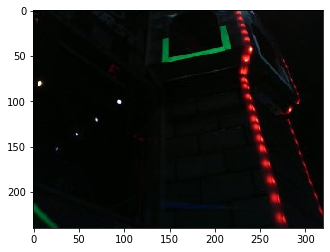

In [4]:
# Change this to load different images
img = cv2.imread('images/2016-cmp-5.jpg')
imshow(img)

# Hello image!

* You can show multiple images next to each other

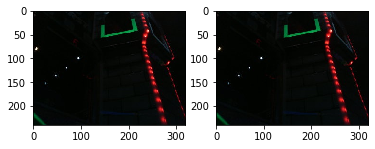

In [5]:
imshow(img, img)

# OpenCV Image Basics

* Images are stored as multidimensional arrays
    * Color images have 3 dimensions: height, width, channel
* Each pixel is a number stored in the array
* Numpy array notation allows you to do operations on individual pixels or ranges of pixels

In [6]:
img[50, 150, :]           # Access a single pixel,

array([ 4, 21,  0], dtype=uint8)

In [7]:
x = img[24:42, 42:100, :]    # Access a range of pixels

# OpenCV Image Basics

* Color is represented by storing combinations of Red, Blue, and Green pixels in separate channels
    * OpenCV uses BGR representation, not RGB
* The amount of each individual color is represented in the individual channel
    * ‘dark’ is zero, ‘bright’ is 255
* Combine the channels to represent a color
    * Green = RGB( 0, 255, 0 )
    * Deep Pink = RGB( 255, 20, 147 )

# OpenCV Image Basics

* Using numpy we can easily fill an image with a single color

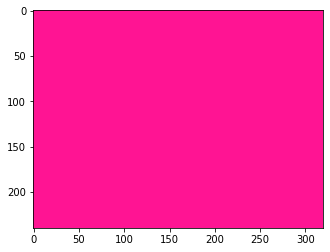

In [8]:
# define image with height=240, width=320, 3 channels
shape = (240, 320, 3)
pink_img = np.empty(shape, dtype=np.uint8)

# Fill every pixel with a single color
pink_img[:] = (147, 20, 255)

imshow(pink_img)

# Practical Example

* 2016 FIRST Stronghold: find targets that are surrounded by retroreflective tape, and shoot boulders into them
* 2017 FIRST Steamworks: use two targets to align to gear holder on the ship

# Practical Example
* Finding gray tape at a distance isn’t particularly easy
    * Key part of image processing is removing as much non-essential information from image 
* We can do better!

# Retroreflective Tape

* It has a useful property -- it reflects light directly back at the source
* What can we do with this property?

* Shine bright LEDs at the target and the tape reflects that color back to the camera
    * Many teams have found that green light works best
* Reduce exposure of camera so only bright light sources are seen 

# A note about exposure

* Webcams support setting the exposure manually (yay)
* Some cameras only allow particular exposure settings 
    * The lifecam is one of them
* OpenCV has bugs, it doesn't set the exposure properly
* Here's a workaround that works on linux:

```sh 
v4l2-ctl -d /dev/video0 -c exposure_auto=1 -c exposure_absolute=10
```

# Retroreflective Tape

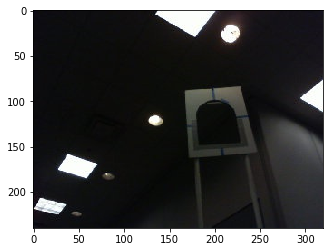

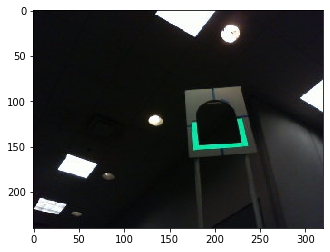

In [9]:
img1 = cv2.imread('images/2016-p0.jpg')
img2 = cv2.imread('images/2016-p1.jpg')
imshow(img1)
imshow(img2)

# Practical Example

Processing steps to find targets:

* Isolate the green portions of the image
* Analyze the green portions to determine targets

**Note**: There are a lot of ways to go about this, I'm just showing you one way

# Blurring the Image

  * Get rid of small artifacts (noise)
  * Makes the target a little more complete
    * Easier for thresholding and contour finding

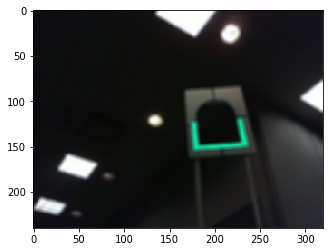

In [10]:
blurred = blur(img2, 2)
imshow(blurred)

# Identify the green

* What is “green” anyways?
    * <span style="color: green">This is green.</span> <span style="color: darkgreen">This is also green.</span>
* To a computer, green is really a range of colors
* An object’s color changes depending on lighting conditions
* We can transform the image to identify colors independent of lighting conditions

# Identify the green

* Convert the image from RGB to HSV
    * Hue: the color
    * Saturation: Colorfulness
    * Value: Brightness

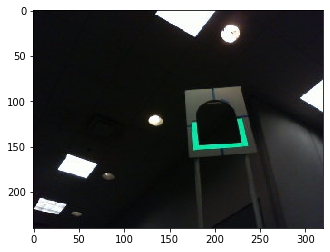

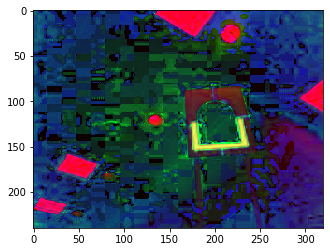

In [11]:
hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
imshow(img2)
imshow(hsv)

# Identify the green

That doesn't show why HSV is useful. Let's look at the individual channels instead.

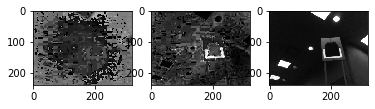

In [13]:
h, s, v = cv2.split(hsv)
imshow(h, s, v)

# Identify the green

* Green is a range of values present in the image
* ‘Threshold’ the image to get rid of the colors that we don’t care about
* Lots of ways to do this
    * Manually specify values
    * Automated methods

# Identify the green

`cv2.inRange` can threshold an image given two ranges of pixels.
* Wanted values are converted to 255
* Unwanted values are now 0

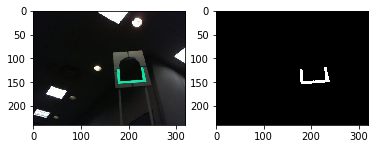

In [14]:
lower = np.array([0, 145, 80])
upper = np.array([255, 255, 255])

filtered = cv2.inRange(hsv, lower, upper)
imshow(img2, filtered)

# Identify the green

Sometimes, you end up with holes in your output

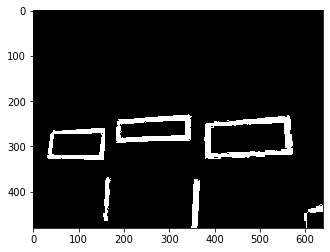

In [15]:
img3 = cv2.imread('images/2013-f0.png')
hsv3 = cv2.cvtColor(img3, cv2.COLOR_BGR2HSV)

# Thresholds are different because different camera/lighting
lower3 = np.array([30, 188, 16])
upper3 = np.array([75, 255, 255])
filtered3 = cv2.inRange(hsv3, lower3, upper3)
imshow(filtered3)

# Identify the green

* We can use a morphological operation to fill in the holes
    * Various types of morphology operations available
* They modify a pixel based on the values of its neighboring pixels
    * The one we use to fill in holes is a “closing” operation

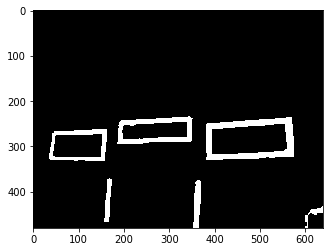

In [16]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2), anchor=(1,1))
output = cv2.morphologyEx(filtered3, cv2.MORPH_CLOSE, kernel,
                          iterations=3)
imshow(output)

# Identifying Targets

Use `findContours()` to find regions of interest
* Returns a list of points bounding each separate blob in the image (called a contour)
* Also returns a hierarchy so you can determine whether a contour is entirely inside another contour

In [17]:
contours, _ = cv2.findContours(output,
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_SIMPLE)

# Identifying Targets

If you want to see what it found, you can draw the found contours.

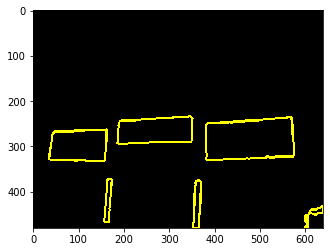

In [19]:
dst = np.zeros(shape=img3.shape, dtype=img3.dtype)
cv2.drawContours(dst, contours, -1, (0, 255, 255), 3)
imshow(dst)
#print(contours[0])

# Identifying Targets

* As you can see, contours aren't the whole story


# Identifying Targets

* Contour analysis
    * Discard non-convex contours
    * Convert to polygon approximation (approxPolyDP)
        * This will turn our multi-vertex contour into a contour with the vertex we see in the real world
    * Discard polygons that aren't the right size


# Magic?

In [20]:
min_width = 20  # in pixels
results = []
centers = []

# Iterate over each contour
for c in contours:

    # Contours are jagged lines -- smooth it out using an approximation
    # .07 seems to work well to keep the contour from being too detailed
    a1 = cv2.approxPolyDP(c, 0.07 * cv2.arcLength(c, True), True)

    # Approximate the points again, smoothing out the hull
    a2 = cv2.approxPolyDP(hull, 0.01 * cv2.arcLength(hull, True), True)

    # We only care about objects that are wider than they are tall, and things wider
    # than a particular width. Only keep things that meet that criteria.
    _, _, w, h = cv2.boundingRect(a2)
    if w < h or w < min_width or len(a2) not in (4, 5):
        continue
    
    results.append(a2)
    M = cv2.moments(c)
    if M["m00"] == 0:
        continue
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # draw the contour and center of the shape on the image
    centers.append((cX, cY))
    #cv2.putText(image, "center", (cX - 20, cY - 20),
    #            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    


NameError: name 'hull' is not defined

# Contour Features
You can find more about contour features and properties [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_table_of_contents_contours/py_table_of_contents_contours.html)

For 2020, we will want to heavily use the convex hull and 

# Magic?

In [ ]:
# Finally, draw out our results
for cnt in centers:
    cv2.circle(dst, (cnt[0], cnt[1]), 1, (255, 255, 255), 2)
imshow(dst)
#print(results[0])

# Identifying Targets

* Sometimes you need to do more work
    * Use ratios to determine which target you're looking at
    * Remove duplicates (inner rectangles)
    * Other types of validation

# Now what?

We have targets... probably should do something with them?

# Calculate angle/distance to target

* We need a couple parts for this
    * Camera Calibration Matrix
    * Camera Distortion Coefficients
    * Object Points
    * Image Points


In [ ]:
# Camera Calibration Matrix
OpenCV has functions built in to get your camera's calibration numbers

Luckily, you don't actually have to understand the code to get your calibration, but you can find the code [here](https://github.com/opencv/opencv/blob/master/samples/python/calibrate.py)

To begin, we need ~25 images taken with the camera of a checkerboard pattern. Joe and I attached one to some pegboard on Monday

To generate the matrix from the raspberry pi, use the `cameraCapture.py` file in the repo.

In [ ]:
# Camera Distortion Coefficients

If you've ever seen a camera that has a fisheye lens, then you know what lens distortion looks like.
This makes it hard to get good distance calculations, so we need to know how distorted the image is.
Luckily, the camera calibration gives us both the intrinsic properties of the camera, as well as the 
distortion coefficients, so we're done!

In [ ]:
# Object Points

Perspective-n-Point works by mapping the 2d pixel coordinates to 3d coordinates in the real world.
In order to map these, we need to define which points we're going to reference. For 2020, the target is a half hexagon
We can use the four outer vertices as our points, with the center of the hexagon as our 'origin'.
To calculate the 3d coordinates for the 4 points, it is helpful to create a CAD drawing and use the measurement tools.

Take some time now and decide what points you'd like to use for vision targeting. You need at least 4, and the points should
  easy to distinguish.

In [ ]:
# Image Points

This is the hardest part of the whole process. Singling out the chosen obejct points, and making sure they're in the right order.
OpenCV doesn't have a strict method of ordering contours, so we have to do some manual checking to make sure the
  contours are in the correct order. We can use the geometries properties to do this.

There are really two steps to getting the correct order: Finding the start point, and then finding the next point.
After you find the second point, you can be sure the rest are in order.

In [ ]:
# Solve PnP
The last part of the problem is solving the PnP equation by calling a single method

```
ret, rvecs, tvecs = cv2.solvePnP(object_points, image_points, cam_matrix, dist_coeffs)
```

`rvecs` will be a vector of the rotations in radians
`tvecs` will be a vector of the translations in whatever unit you specify for the object points. This tells us the 
  distance to the target

# Now What?

* Send data via NetworkTables

* ... I forgot to write this slide. It's easy, I promise.

# Where to run the image processing

* RoboRIO
    * RoboRIO is relatively slow, OpenCV eats a lot of CPU
        * Hint: Make the images small (320x240)
    * Less hardware to deal with
    * FIRST intends to install OpenCV by default in 2017
    

# Where to run the image processing

* Driver Station
    * Streaming images to OpenCV is possible
        * Various latency bugs
    * Latency is an issue here
    * mDNS problems (hopefully will be resolved in 2017)

# Where to run the image processing

* Coprocessor (Jetson, Raspberry PI, Nexus 5)
    * Lots of teams do this
    * More hardware to deal with
    * Potentially higher fidelity processing

# Want code?

* Working OpenCV code integrated with mjpg-streamer
    * https://github.com/frc2423/2016/tree/master/OpenCV
    * Includes code for storing images onto USB drive during matches
    * Don't let our robot's performance fool you... :(
    
* The stuff we did here will be available sometime tonight
    * https://github.com/virtuald/frc-imageprocessing-workshop-2016

# If you want more

* Team 254 gave an excellent presentation at CMP in 2016
    * https://goo.gl/mppi4E
    * Video/audio: http://www.chiefdelphi.com/forums/showthread.php?t=147568&page=3
    * Latency compensation is an excellent technique presented here

# Resources

* Python 3.5.x
    * https://www.python.org/downloads/
* Learn Python
    * http://www.codecademy.com/tracks/python

* OpenCV 3.1.0
    * http://opencv.org

* NumPy
    * Official site: http://www.numpy.org

# Resources

* roborio-packages
    * https://github.com/robotpy/roborio-packages
* OpenCV for RoboRIO
    * https://github.com/robotpy/roborio-opencv
* mjpg-streamer for RoboRIO
    * https://github.com/robotpy/mjpg-streamer

# Resources

* pynetworktables
    * source code + examples @
      https://github.com/robotpy/pynetworktables

* Edit & debug python code using Eclipse
    * Pydev: http://pydev.org/

# One more thing...

FIRSTwiki: https://firstwiki.github.io

* Publicly editable repository of information related to FIRST Robotics
    * Technical topics
    * Non-technical
    * Team pages
* Add content to your team’s page!

# <center>Questions?</center>